In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import pickle

from constants.constants import *
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_sample_weight

# Embeds graphs in Jupyter notebook (instead of pop-ups)
%matplotlib inline

# pd.set_option('display.max_columns', None) # show all columns

Try using Random Forest with Boruta Preprocessor to predict wins and losses

### Note: If the model does not exist, please run feature_engineering.ipynb

In [2]:
with open(BORUTA_FEATURES_PATH, 'r') as f:
    selected_features = json.load(f)
with open('data/machine_learning/pkl/processor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

df_train_preprocessed, df_test_preprocessed, y_train_encoded, y_test_encoded = preprocessor.get_processed_data() # contains team details
df_train_preprocessed_features = df_train_preprocessed[selected_features]
df_test_preprocessed_features = df_test_preprocessed[selected_features]

Preprocess the Predicted Data as well

In [3]:
prediction_df = pd.read_csv('data/machine_learning/2023_predict.csv')
prediction_df = preprocessor.fit_data_to_predict(prediction_df)
prediction_df = prediction_df[['team', 'opponent', 'country', *selected_features]]

In [4]:
# Draws seem to be harder to predict
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train_encoded)

# Store the metrics for each model in a dictionary
model_metrics = {}

### Helper Function

In [5]:
def evaluate_model(model, X_train, y_train, X_test, y_test, df_2023, supports_sample_weight=True):

    if supports_sample_weight:
        model.fit(X_train, y_train, sample_weight=sample_weight)
    else:
        model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    model_name = model.__class__.__name__

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
    recall = recall_score(y_test, predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_test, predictions, average='weighted', zero_division=0)

    print(f"Model: {model_name}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

    model_metrics[model_name] = metrics

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, predictions, target_names=preprocessor.target_encoder.classes_, zero_division=0))

    print("Confusion Matrix:")
    encoded_labels = np.unique(np.concatenate((y_test, predictions)))
    labels = preprocessor.target_encoder.inverse_transform(encoded_labels)
    conf_mat = confusion_matrix(y_test, predictions, labels=encoded_labels)
    plt.figure(figsize=(10, 7))  # Size of the figure
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    df_copy = df_test_preprocessed.copy()
    df_copy['actual_result'] = preprocessor.target_encoder.inverse_transform(y_test)
    predicted_labels = preprocessor.target_encoder.inverse_transform(predictions)
    df_copy['predicted_result'] = predicted_labels
    display(df_copy[['country', 'team', 'opponent', 'is_home', 'predicted_result']])

    df_2023_copy = df_2023.copy()
    predictions_2023 = model.predict(df_2023.drop(['team', 'opponent', 'country'], axis=1))
    predicted_labels_2023 = preprocessor.target_encoder.inverse_transform(predictions_2023)
    df_2023_copy['predicted_result'] = predicted_labels_2023
    final_df = df_2023_copy[['country', 'team', 'opponent', 'is_home', 'predicted_result']]
    final_df.to_csv(f"./data/machine_learning/predictions/{model_name}.csv", index=False)

### Random Forest Classifier

Model: RandomForestClassifier
Accuracy: 0.4750173490631506
Precision: 0.4651722133848868
Recall: 0.4750173490631506
F1 Score: 0.4691437673337992

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           D       0.27      0.23      0.25       664
           L       0.51      0.56      0.53      1091
           W       0.53      0.54      0.54      1127

    accuracy                           0.48      2882
   macro avg       0.44      0.44      0.44      2882
weighted avg       0.47      0.48      0.47      2882

Confusion Matrix:


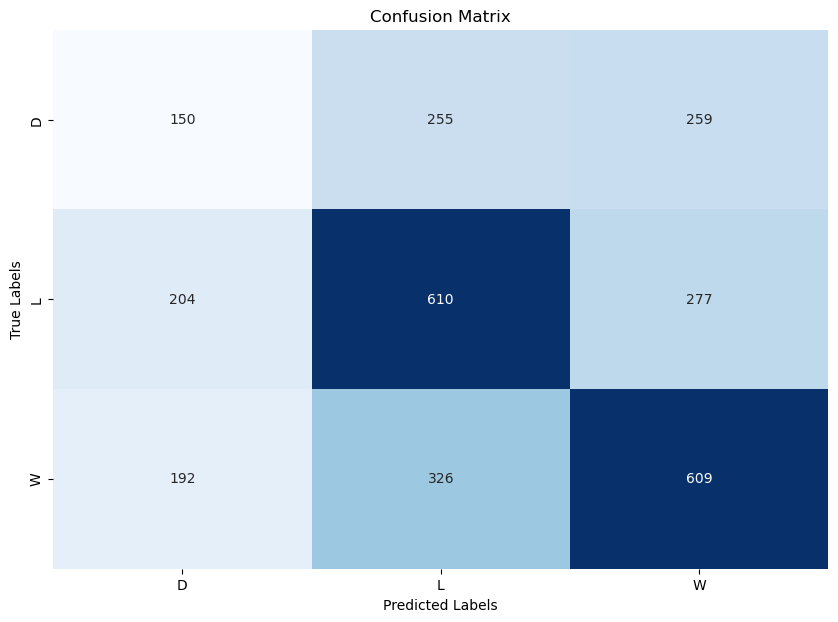

,country,team,opponent,is_home,predicted_result
11833,ITA,Juventus,Napoli,1.0,W
7039,FRA,Bordeaux,St Etienne,0.0,L
8614,FRA,Lorient,Nice,1.0,L
3798,ENG,Southampton,Crystal Palace,1.0,L
9303,ENG,Southampton,Leicester,0.0,D
...,...,...,...,...,...
7525,SPA,Mallorca,Villarreal,1.0,W
1434,GER,RB Leipzig,Hertha Berlin,1.0,W
14390,FRA,Marseille,Lille,0.0,W
92,ENG,Liverpool,Norwich,1.0,W


In [6]:
from sklearn.ensemble import RandomForestClassifier
evaluate_model(RandomForestClassifier(random_state=42), df_train_preprocessed_features, y_train_encoded, df_test_preprocessed_features, y_test_encoded, prediction_df)

### Logistic Regression

Model: LogisticRegression
Accuracy: 0.5024288688410826
Precision: 0.517026112386633
Recall: 0.5024288688410826
F1 Score: 0.508562468947365

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           D       0.29      0.35      0.32       664
           L       0.59      0.55      0.57      1091
           W       0.58      0.54      0.56      1127

    accuracy                           0.50      2882
   macro avg       0.49      0.48      0.48      2882
weighted avg       0.52      0.50      0.51      2882

Confusion Matrix:


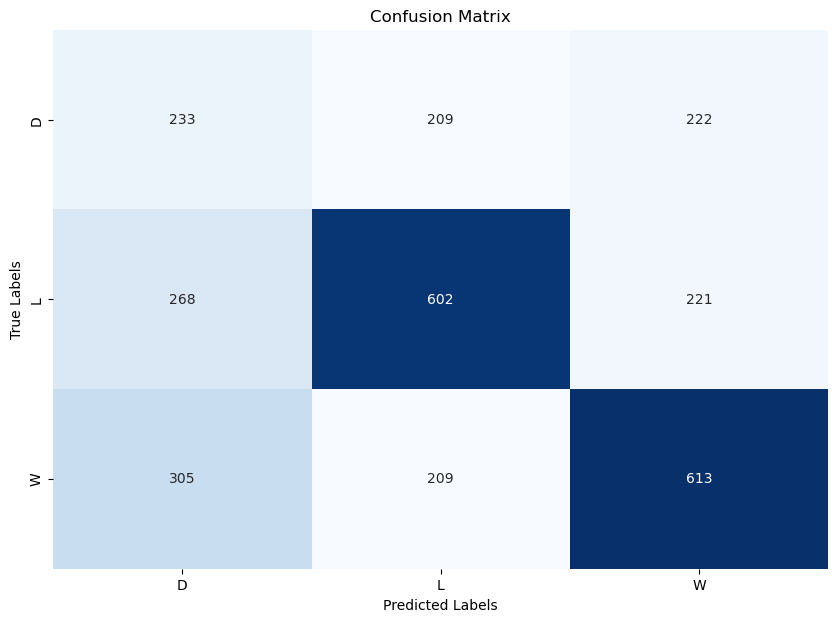

,country,team,opponent,is_home,predicted_result
11833,ITA,Juventus,Napoli,1.0,W
7039,FRA,Bordeaux,St Etienne,0.0,L
8614,FRA,Lorient,Nice,1.0,D
3798,ENG,Southampton,Crystal Palace,1.0,W
9303,ENG,Southampton,Leicester,0.0,L
...,...,...,...,...,...
7525,SPA,Mallorca,Villarreal,1.0,D
1434,GER,RB Leipzig,Hertha Berlin,1.0,W
14390,FRA,Marseille,Lille,0.0,D
92,ENG,Liverpool,Norwich,1.0,W


In [7]:
from sklearn.linear_model import LogisticRegression
evaluate_model(LogisticRegression(random_state=42), df_train_preprocessed_features, y_train_encoded, df_test_preprocessed_features, y_test_encoded, prediction_df)

### Support Vector Machines

Model: SVC
Accuracy: 0.49826509368494104
Precision: 0.521564101835813
Recall: 0.49826509368494104
F1 Score: 0.5069503818780905

Classification Report for SVC:
              precision    recall  f1-score   support

           D       0.29      0.39      0.34       664
           L       0.59      0.54      0.56      1091
           W       0.59      0.52      0.55      1127

    accuracy                           0.50      2882
   macro avg       0.49      0.48      0.48      2882
weighted avg       0.52      0.50      0.51      2882

Confusion Matrix:


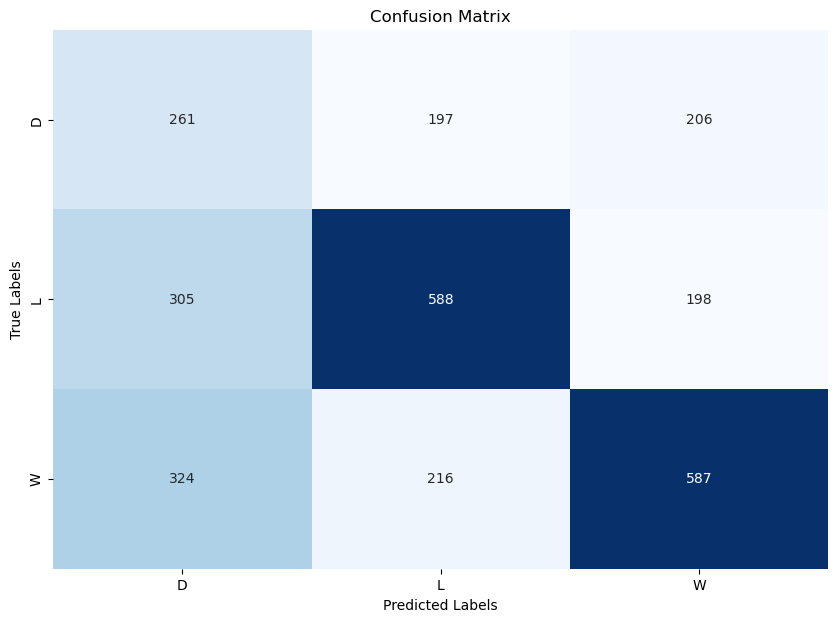

,country,team,opponent,is_home,predicted_result
11833,ITA,Juventus,Napoli,1.0,W
7039,FRA,Bordeaux,St Etienne,0.0,L
8614,FRA,Lorient,Nice,1.0,L
3798,ENG,Southampton,Crystal Palace,1.0,W
9303,ENG,Southampton,Leicester,0.0,L
...,...,...,...,...,...
7525,SPA,Mallorca,Villarreal,1.0,D
1434,GER,RB Leipzig,Hertha Berlin,1.0,W
14390,FRA,Marseille,Lille,0.0,W
92,ENG,Liverpool,Norwich,1.0,W


In [8]:
from sklearn.svm import SVC
evaluate_model(SVC(random_state=42), df_train_preprocessed_features, y_train_encoded, df_test_preprocessed_features, y_test_encoded, prediction_df)

### Decision Tree

Model: DecisionTreeClassifier
Accuracy: 0.4226231783483692
Precision: 0.4297667041199092
Recall: 0.4226231783483692
F1 Score: 0.42580107249568133

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

           D       0.25      0.28      0.26       664
           L       0.48      0.45      0.47      1091
           W       0.49      0.47      0.48      1127

    accuracy                           0.42      2882
   macro avg       0.41      0.40      0.40      2882
weighted avg       0.43      0.42      0.43      2882

Confusion Matrix:


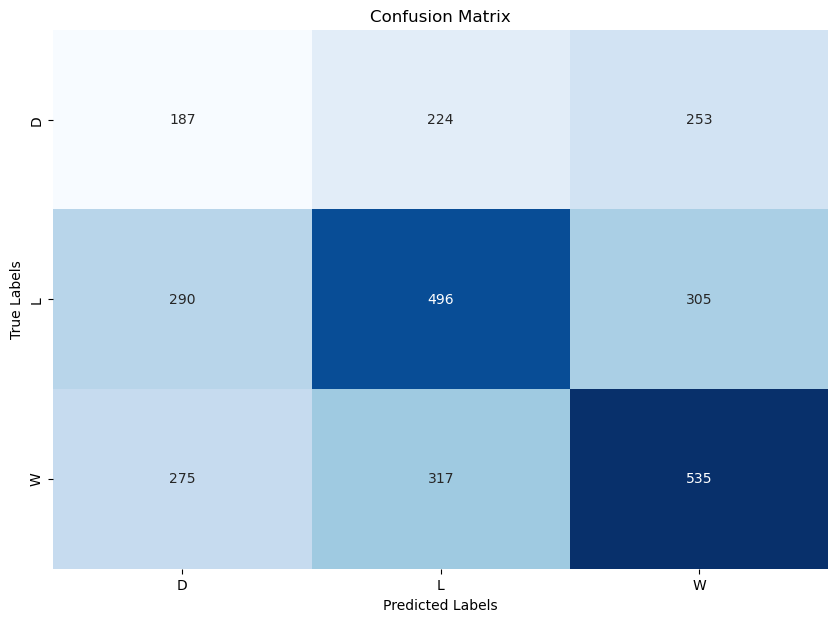

,country,team,opponent,is_home,predicted_result
11833,ITA,Juventus,Napoli,1.0,W
7039,FRA,Bordeaux,St Etienne,0.0,L
8614,FRA,Lorient,Nice,1.0,L
3798,ENG,Southampton,Crystal Palace,1.0,L
9303,ENG,Southampton,Leicester,0.0,L
...,...,...,...,...,...
7525,SPA,Mallorca,Villarreal,1.0,D
1434,GER,RB Leipzig,Hertha Berlin,1.0,W
14390,FRA,Marseille,Lille,0.0,W
92,ENG,Liverpool,Norwich,1.0,W


In [9]:
from sklearn.tree import DecisionTreeClassifier
evaluate_model(DecisionTreeClassifier(random_state=42), df_train_preprocessed_features, y_train_encoded, df_test_preprocessed_features, y_test_encoded, prediction_df)

### K-Neighbours

The model's fit method does not support a sample_weight parameter

Model: KNeighborsClassifier
Accuracy: 0.4437890353920888
Precision: 0.46067603024891174
Recall: 0.4437890353920888
F1 Score: 0.44793817457673707

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           D       0.27      0.33      0.29       664
           L       0.49      0.54      0.52      1091
           W       0.54      0.42      0.47      1127

    accuracy                           0.44      2882
   macro avg       0.43      0.43      0.43      2882
weighted avg       0.46      0.44      0.45      2882

Confusion Matrix:


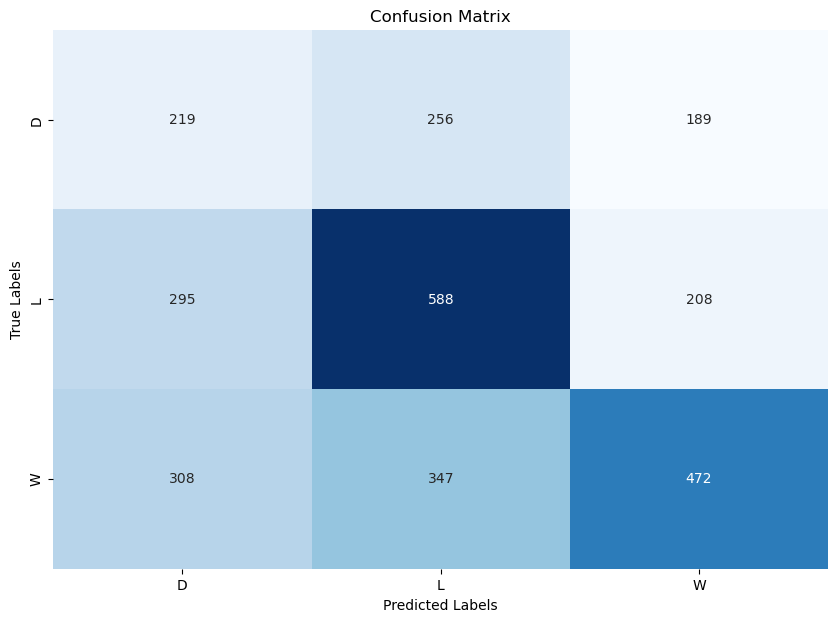

,country,team,opponent,is_home,predicted_result
11833,ITA,Juventus,Napoli,1.0,L
7039,FRA,Bordeaux,St Etienne,0.0,L
8614,FRA,Lorient,Nice,1.0,L
3798,ENG,Southampton,Crystal Palace,1.0,D
9303,ENG,Southampton,Leicester,0.0,D
...,...,...,...,...,...
7525,SPA,Mallorca,Villarreal,1.0,D
1434,GER,RB Leipzig,Hertha Berlin,1.0,W
14390,FRA,Marseille,Lille,0.0,W
92,ENG,Liverpool,Norwich,1.0,W


In [10]:
from sklearn.neighbors import KNeighborsClassifier
evaluate_model(KNeighborsClassifier(), df_train_preprocessed_features, y_train_encoded, df_test_preprocessed_features, y_test_encoded, prediction_df, supports_sample_weight=False)

### Naive Bayes

It supports sample weight, but using sample weight will cause it to predict too many draws

Model: GaussianNB
Accuracy: 0.4823039555863983
Precision: 0.49261242292211843
Recall: 0.4823039555863983
F1 Score: 0.48677216313562677

Classification Report for GaussianNB:
              precision    recall  f1-score   support

           D       0.28      0.33      0.30       664
           L       0.55      0.53      0.54      1091
           W       0.57      0.53      0.55      1127

    accuracy                           0.48      2882
   macro avg       0.46      0.46      0.46      2882
weighted avg       0.49      0.48      0.49      2882

Confusion Matrix:


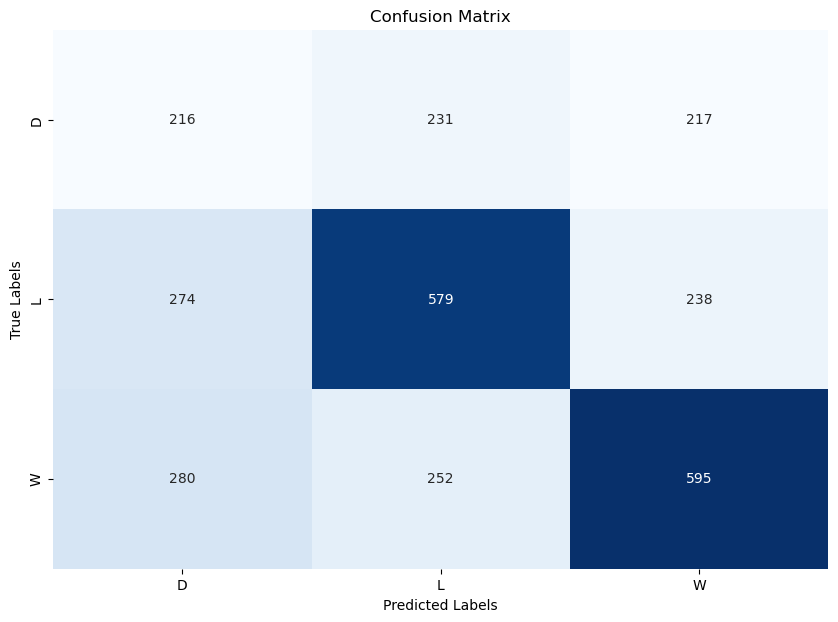

,country,team,opponent,is_home,predicted_result
11833,ITA,Juventus,Napoli,1.0,W
7039,FRA,Bordeaux,St Etienne,0.0,W
8614,FRA,Lorient,Nice,1.0,D
3798,ENG,Southampton,Crystal Palace,1.0,D
9303,ENG,Southampton,Leicester,0.0,L
...,...,...,...,...,...
7525,SPA,Mallorca,Villarreal,1.0,L
1434,GER,RB Leipzig,Hertha Berlin,1.0,D
14390,FRA,Marseille,Lille,0.0,W
92,ENG,Liverpool,Norwich,1.0,W


In [11]:
from sklearn.naive_bayes import GaussianNB
evaluate_model(GaussianNB(), df_train_preprocessed_features, y_train_encoded, df_test_preprocessed_features, y_test_encoded, prediction_df, supports_sample_weight=False)

### Gradient Boosting

Model: GradientBoostingClassifier
Accuracy: 0.5003469812630118
Precision: 0.5142225289149429
Recall: 0.5003469812630118
F1 Score: 0.5063100689540908

Classification Report for GradientBoostingClassifier:
              precision    recall  f1-score   support

           D       0.28      0.33      0.30       664
           L       0.58      0.55      0.56      1091
           W       0.59      0.55      0.57      1127

    accuracy                           0.50      2882
   macro avg       0.48      0.48      0.48      2882
weighted avg       0.51      0.50      0.51      2882

Confusion Matrix:


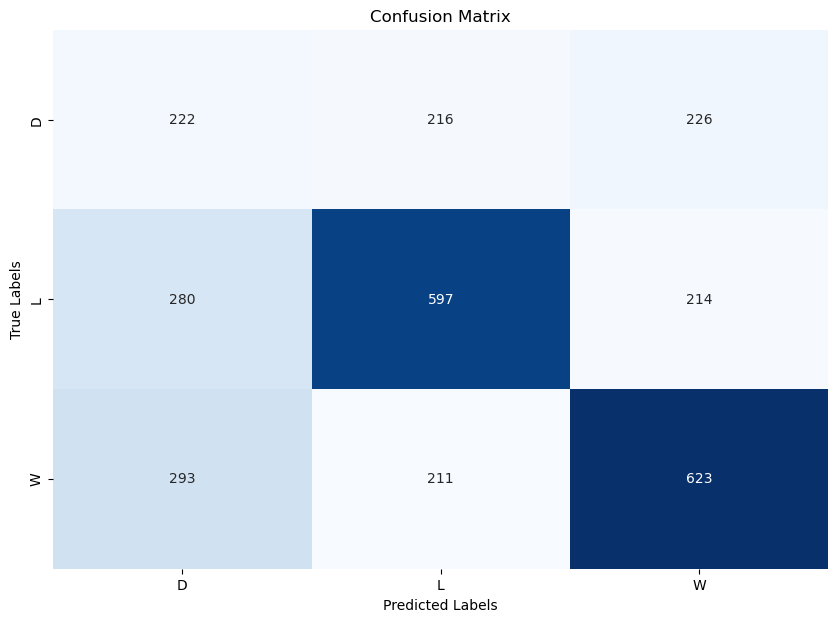

,country,team,opponent,is_home,predicted_result
11833,ITA,Juventus,Napoli,1.0,W
7039,FRA,Bordeaux,St Etienne,0.0,L
8614,FRA,Lorient,Nice,1.0,D
3798,ENG,Southampton,Crystal Palace,1.0,D
9303,ENG,Southampton,Leicester,0.0,L
...,...,...,...,...,...
7525,SPA,Mallorca,Villarreal,1.0,L
1434,GER,RB Leipzig,Hertha Berlin,1.0,W
14390,FRA,Marseille,Lille,0.0,D
92,ENG,Liverpool,Norwich,1.0,W


In [12]:
from sklearn.ensemble import GradientBoostingClassifier
evaluate_model(GradientBoostingClassifier(random_state=42), df_train_preprocessed_features, y_train_encoded, df_test_preprocessed_features, y_test_encoded, prediction_df)

### Extra Trees

Model: ExtraTreesClassifier
Accuracy: 0.4902845246356697
Precision: 0.4707347637346044
Recall: 0.4902845246356697
F1 Score: 0.47755750031672634

Classification Report for ExtraTreesClassifier:
              precision    recall  f1-score   support

           D       0.27      0.18      0.22       664
           L       0.52      0.59      0.55      1091
           W       0.54      0.58      0.56      1127

    accuracy                           0.49      2882
   macro avg       0.44      0.45      0.44      2882
weighted avg       0.47      0.49      0.48      2882

Confusion Matrix:


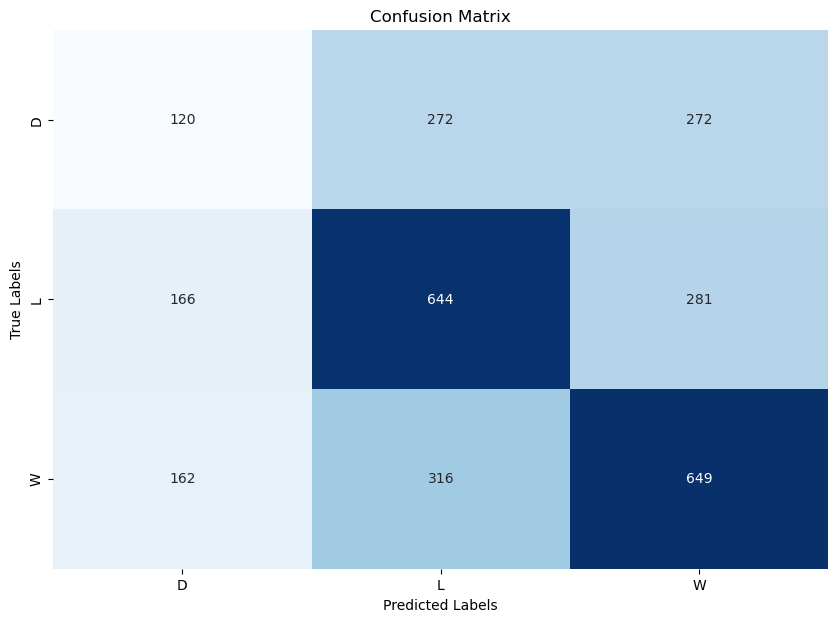

,country,team,opponent,is_home,predicted_result
11833,ITA,Juventus,Napoli,1.0,W
7039,FRA,Bordeaux,St Etienne,0.0,L
8614,FRA,Lorient,Nice,1.0,L
3798,ENG,Southampton,Crystal Palace,1.0,L
9303,ENG,Southampton,Leicester,0.0,L
...,...,...,...,...,...
7525,SPA,Mallorca,Villarreal,1.0,W
1434,GER,RB Leipzig,Hertha Berlin,1.0,W
14390,FRA,Marseille,Lille,0.0,W
92,ENG,Liverpool,Norwich,1.0,W


In [13]:
from sklearn.ensemble import ExtraTreesClassifier
evaluate_model(ExtraTreesClassifier(random_state=42), df_train_preprocessed_features, y_train_encoded, df_test_preprocessed_features, y_test_encoded, prediction_df)

In [17]:
metrics_df = pd.DataFrame(model_metrics).T
metrics_df.to_csv('data/machine_learning/model_metrics.csv')

Proceed to deep_learning.ipynb